# Galaxy10 Pipeline - Ensemble Training

This notebook trains multiple classifiers on concatenated embeddings:
- **ViT-S/16**: 384-dimensional embeddings
- **EfficientNetV2-S**: 1,280-dimensional embeddings
- **CLIP**: 512-dimensional embeddings

**Total Feature Dimension**: 2,176 (384 + 1,280 + 512)

**Classifiers**:
-   Logistic Regression
-   Random Forest
-   Extra Trees
-   XGBoost
-   K-Nearest Neighbors

**Features**:
- 5-fold stratified cross-validation
- Automatic best model selection
- Full CPU parallelization

## 1. Setup and Imports

In [1]:
import sys
import os
import time
import h5py
import numpy as np
import pandas as pd
import joblib
import json
from multiprocessing import cpu_count

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_curve, auc, roc_auc_score, accuracy_score,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler, label_binarize
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.config import DATASET_PATH, N_JOBS, EMBEDDINGS_DIR, MODELS_DIR

print(f"✓ Imports complete")
print(f"✓ Using {N_JOBS} CPU cores for parallel processing")

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

Configuration loaded: Using 21 CPU cores for parallel processing
✓ Imports complete
✓ Using 21 CPU cores for parallel processing


## 2. Load Dataset Labels

In [2]:
print(f"Loading labels from: {DATASET_PATH}")

with h5py.File(DATASET_PATH, 'r') as f:
    labels = np.array(f['ans'])

print(f"✓ Loaded {len(labels):,} labels")
print(f"✓ Labels shape: {labels.shape}")
print(f"✓ Unique classes: {np.unique(labels)}")

# Class names
CLASS_NAMES = [
    "Disturbed Galaxies",
    "Merging Galaxies",
    "Round Smooth",
    "In-between Round Smooth",
    "Cigar-Shaped Smooth",
    "Barred Spiral",
    "Unbarred Tight Spiral",
    "Unbarred Loose Spiral",
    "Edge-on with Bulge",
    "Edge-on without Bulge"
]

Loading labels from: /home/salix/Documents/Galaxy10_DECals.h5
✓ Loaded 17,736 labels
✓ Labels shape: (17736,)
✓ Unique classes: [0 1 2 3 4 5 6 7 8 9]


## 3. Load Embeddings

In [3]:
print("="*70)
print("Loading Embeddings")
print("="*70)

# Load ViT embeddings
vit_path = os.path.join(EMBEDDINGS_DIR, 'vit_embeddings.npy')
print(f"\nLoading ViT embeddings from: {vit_path}")
vit_embeddings = np.load(vit_path)
print(f"✓ ViT shape: {vit_embeddings.shape}")

# Load EfficientNet embeddings
efficientnet_path = os.path.join(EMBEDDINGS_DIR, 'efficientnet_embeddings.npy')
print(f"\nLoading EfficientNet embeddings from: {efficientnet_path}")
efficientnet_embeddings = np.load(efficientnet_path)
print(f"✓ EfficientNet shape: {efficientnet_embeddings.shape}")

# Load CLIP embeddings
clip_path = os.path.join(EMBEDDINGS_DIR, 'clip_embeddings.npy')
print(f"\nLoading CLIP embeddings from: {clip_path}")
clip_embeddings = np.load(clip_path)
print(f"✓ CLIP shape: {clip_embeddings.shape}")

print(f"\n✓ All embeddings loaded successfully")

Loading Embeddings

Loading ViT embeddings from: artifacts/embeddings/vit_embeddings.npy
✓ ViT shape: (17736, 384)

Loading EfficientNet embeddings from: artifacts/embeddings/efficientnet_embeddings.npy
✓ EfficientNet shape: (17736, 1280)

Loading CLIP embeddings from: artifacts/embeddings/clip_embeddings.npy
✓ CLIP shape: (17736, 512)

✓ All embeddings loaded successfully


## 4. Concatenate Embeddings

In [4]:
print("="*70)
print("Concatenating Embeddings")
print("="*70)

# Concatenate all embeddings horizontally
X = np.concatenate([
    vit_embeddings,
    efficientnet_embeddings,
    clip_embeddings
], axis=1)

y = labels

print(f"\n✓ Concatenated embeddings shape: {X.shape}")
print(f"✓ Total feature dimension: {X.shape[1]} (384 + 1280 + 512)")
print(f"✓ Labels shape: {y.shape}")
print(f"\n Feature breakdown:")
print(f"  • ViT-S/16: {vit_embeddings.shape[1]} dimensions")
print(f"  • EfficientNetV2-S: {efficientnet_embeddings.shape[1]} dimensions")
print(f"  • CLIP: {clip_embeddings.shape[1]} dimensions")

Concatenating Embeddings

✓ Concatenated embeddings shape: (17736, 2176)
✓ Total feature dimension: 2176 (384 + 1280 + 512)
✓ Labels shape: (17736,)

 Feature breakdown:
  • ViT-S/16: 384 dimensions
  • EfficientNetV2-S: 1280 dimensions
  • CLIP: 512 dimensions


## 5. Standardize Features

In [5]:
print("="*70)
print("Standardizing Features")
print("="*70)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✓ Features standardized")
print(f"✓ Mean: {X_scaled.mean():.6f}")
print(f"✓ Std: {X_scaled.std():.6f}")

# Save scaler for later use
os.makedirs(MODELS_DIR, exist_ok=True)
scaler_path = os.path.join(MODELS_DIR, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

Standardizing Features

✓ Features standardized
✓ Mean: 0.000000
✓ Std: 1.000000
✓ Scaler saved to: artifacts/models/scaler.pkl


## 6. Initialize Classifiers

In [6]:
print("="*70)
print("Initializing Classifiers")
print("="*70)

classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        n_jobs=N_JOBS,
        random_state=42,
        verbose=0
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        n_jobs=N_JOBS,
        random_state=42,
        verbose=0
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=20,
        n_jobs=N_JOBS,
        random_state=42,
        verbose=0
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=N_JOBS,
        random_state=42,
        verbosity=0,
        eval_metric='mlogloss'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=N_JOBS
    )
}

print(f"\n✓ Initialized {len(classifiers)} classifiers:")
for name in classifiers.keys():
    print(f"  • {name}")

Initializing Classifiers

✓ Initialized 5 classifiers:
  • Logistic Regression
  • Random Forest
  • Extra Trees
  • XGBoost
  • K-Nearest Neighbors


## 7. Train and Evaluate Classifiers

In [7]:
print("="*70)
print("Training Classifiers with 5-Fold Cross-Validation")
print("="*70)

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, clf in classifiers.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    # Cross-validation
    cv_scores = cross_val_score(
        clf, X_scaled, y, 
        cv=cv, 
        scoring='f1_weighted',
        n_jobs=1  # Already parallelized within classifiers
    )
    
    elapsed = time.time() - start_time
    
    # Store results
    results[name] = {
        'cv_scores': cv_scores.tolist(),
        'mean_f1': cv_scores.mean(),
        'std_f1': cv_scores.std(),
        'training_time': elapsed
    }
    
    print(f"\n Cross-validation complete")
    print(f" F1 Scores: {cv_scores}")
    print(f" Mean F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f" Training time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

print(f"\n{'='*70}")
print(" All classifiers trained")
print(f"{'='*70}")

Training Classifiers with 5-Fold Cross-Validation

Training: Logistic Regression

 Cross-validation complete
 F1 Scores: [0.66421785 0.6600035  0.64193266 0.6550782  0.65834044]
 Mean F1: 0.6559 ± 0.0076
 Training time: 171.67 seconds (2.86 minutes)

Training: Random Forest

 Cross-validation complete
 F1 Scores: [0.58655273 0.598658   0.5897279  0.57456415 0.58234128]
 Mean F1: 0.5864 ± 0.0080
 Training time: 115.69 seconds (1.93 minutes)

Training: Extra Trees

 Cross-validation complete
 F1 Scores: [0.57473329 0.58357249 0.56526706 0.57308522 0.56973269]
 Mean F1: 0.5733 ± 0.0061
 Training time: 23.44 seconds (0.39 minutes)

Training: XGBoost

 Cross-validation complete
 F1 Scores: [0.68318616 0.68951517 0.67395726 0.67821493 0.68445705]
 Mean F1: 0.6819 ± 0.0053
 Training time: 1908.37 seconds (31.81 minutes)

Training: K-Nearest Neighbors

 Cross-validation complete
 F1 Scores: [0.53473705 0.53710566 0.51884553 0.53195488 0.52547062]
 Mean F1: 0.5296 ± 0.0066
 Training time: 9.03 

## 8. Compare Results

In [8]:
print("="*70)
print("Classifier Comparison")
print("="*70)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Classifier': name,
        'Mean F1': f"{res['mean_f1']:.4f}",
        'Std F1': f"{res['std_f1']:.4f}",
        'Training Time (min)': f"{res['training_time']/60:.2f}"
    }
    for name, res in results.items()
])

# Sort by Mean F1
comparison_df['Mean F1 (numeric)'] = comparison_df['Mean F1'].astype(float)
comparison_df = comparison_df.sort_values('Mean F1 (numeric)', ascending=False)
comparison_df = comparison_df.drop('Mean F1 (numeric)', axis=1)

print("\n Results:")
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = max(results.items(), key=lambda x: x[1]['mean_f1'])[0]
best_f1 = results[best_model_name]['mean_f1']

print(f"\n Best Model: {best_model_name}")
print(f" Best F1 Score: {best_f1:.4f}")

Classifier Comparison

 Results:
         Classifier Mean F1 Std F1 Training Time (min)
            XGBoost  0.6819 0.0053               31.81
Logistic Regression  0.6559 0.0076                2.86
      Random Forest  0.5864 0.0080                1.93
        Extra Trees  0.5733 0.0061                0.39
K-Nearest Neighbors  0.5296 0.0066                0.15

 Best Model: XGBoost
 Best F1 Score: 0.6819


## 9. Visualize Results

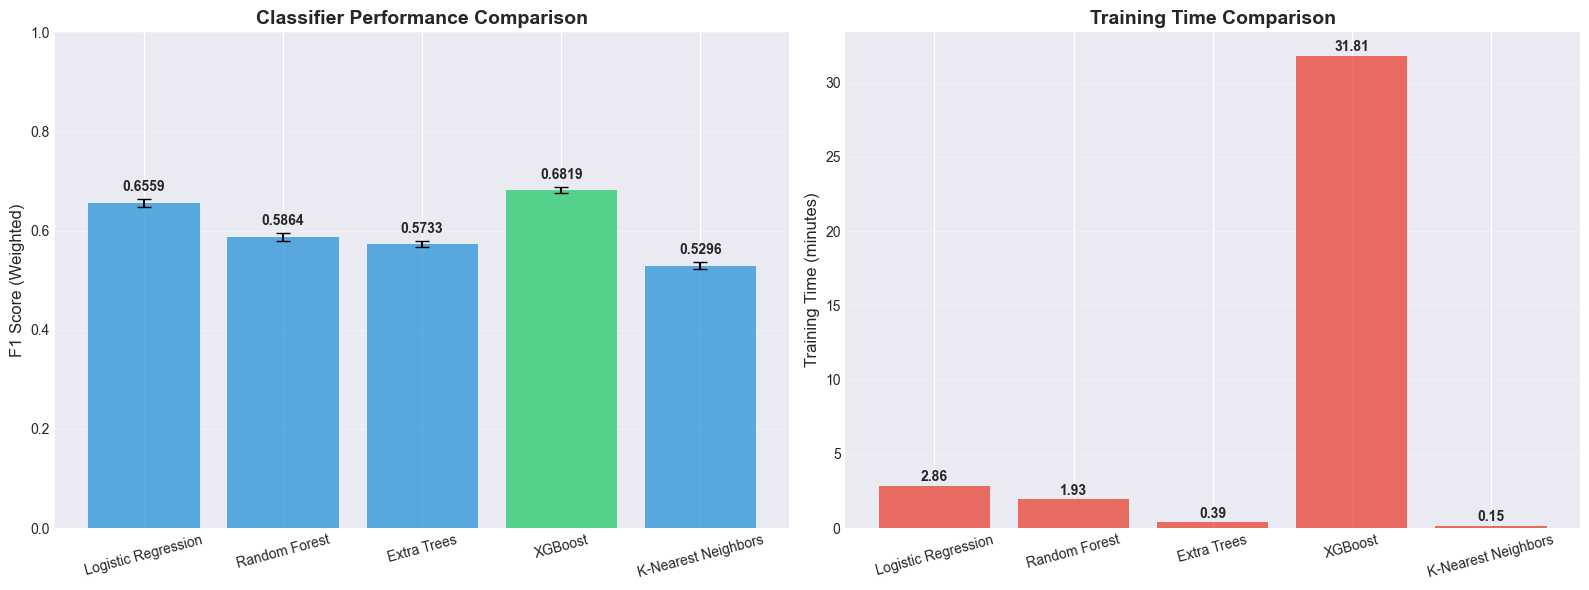

 Saved comparison plot to artifacts/visualizations/classifier_comparison.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1 Scores Comparison
ax1 = axes[0]
model_names = list(results.keys())
mean_f1s = [results[name]['mean_f1'] for name in model_names]
std_f1s = [results[name]['std_f1'] for name in model_names]

colors = ['#2ecc71' if name == best_model_name else '#3498db' for name in model_names]
bars = ax1.bar(model_names, mean_f1s, yerr=std_f1s, capsize=5, color=colors, alpha=0.8)
ax1.set_ylabel('F1 Score (Weighted)', fontsize=12)
ax1.set_title('Classifier Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=15)

# Add value labels on bars
for bar, mean, std in zip(bars, mean_f1s, std_f1s):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
            f'{mean:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Training Time Comparison
ax2 = axes[1]
training_times = [results[name]['training_time']/60 for name in model_names]
bars2 = ax2.bar(model_names, training_times, color='#e74c3c', alpha=0.8)
ax2.set_ylabel('Training Time (minutes)', fontsize=12)
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=15)

# Add value labels
for bar, time_val in zip(bars2, training_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{time_val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../artifacts/visualizations/classifier_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

print(" Saved comparison plot to artifacts/visualizations/classifier_comparison.png")

## 10. Train Best Model on Full Dataset

In [10]:
print("="*70)
print(f"Training Best Model ({best_model_name}) on Full Dataset")
print("="*70)

# Get best classifier
best_clf = classifiers[best_model_name]

# Train on full dataset
start_time = time.time()
best_clf.fit(X_scaled, y)
elapsed = time.time() - start_time

print(f"\n✓ Training complete in {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

# Make predictions
y_pred = best_clf.predict(X_scaled)

# Calculate metrics
train_f1 = f1_score(y, y_pred, average='weighted')
print(f" Training F1 Score: {train_f1:.4f}")

Training Best Model (XGBoost) on Full Dataset

✓ Training complete in 421.28 seconds (7.02 minutes)
 Training F1 Score: 0.9966


## 11. Per-Class Performance

In [11]:
print("="*70)
print("Per-Class Performance Analysis")
print("="*70)

# Generate classification report
report = classification_report(y, y_pred, target_names=CLASS_NAMES, output_dict=True)

# Create DataFrame
per_class_df = pd.DataFrame([
    {
        'Class': class_name,
        'Precision': f"{report[class_name]['precision']:.4f}",
        'Recall': f"{report[class_name]['recall']:.4f}",
        'F1-Score': f"{report[class_name]['f1-score']:.4f}",
        'Support': int(report[class_name]['support'])
    }
    for class_name in CLASS_NAMES
])

print("\n Per-Class Metrics:")
print(per_class_df.to_string(index=False))

# Save to CSV
per_class_path = '../artifacts/visualizations/per_class_metrics.csv'
per_class_df.to_csv(per_class_path, index=False)
print(f"\n Saved per-class metrics to {per_class_path}")

Per-Class Performance Analysis

 Per-Class Metrics:
                  Class Precision Recall F1-Score  Support
     Disturbed Galaxies    0.9925 0.9796   0.9860     1081
       Merging Galaxies    0.9946 0.9978   0.9962     1853
           Round Smooth    0.9977 0.9985   0.9981     2645
In-between Round Smooth    0.9970 1.0000   0.9985     2027
    Cigar-Shaped Smooth    1.0000 0.9970   0.9985      334
          Barred Spiral    0.9980 0.9995   0.9988     2043
  Unbarred Tight Spiral    0.9962 0.9984   0.9973     1829
  Unbarred Loose Spiral    0.9943 0.9928   0.9935     2628
     Edge-on with Bulge    0.9993 0.9979   0.9986     1423
  Edge-on without Bulge    0.9979 0.9979   0.9979     1873

 Saved per-class metrics to ../artifacts/visualizations/per_class_metrics.csv


## 12. Confusion Matrix

Generating Confusion Matrix


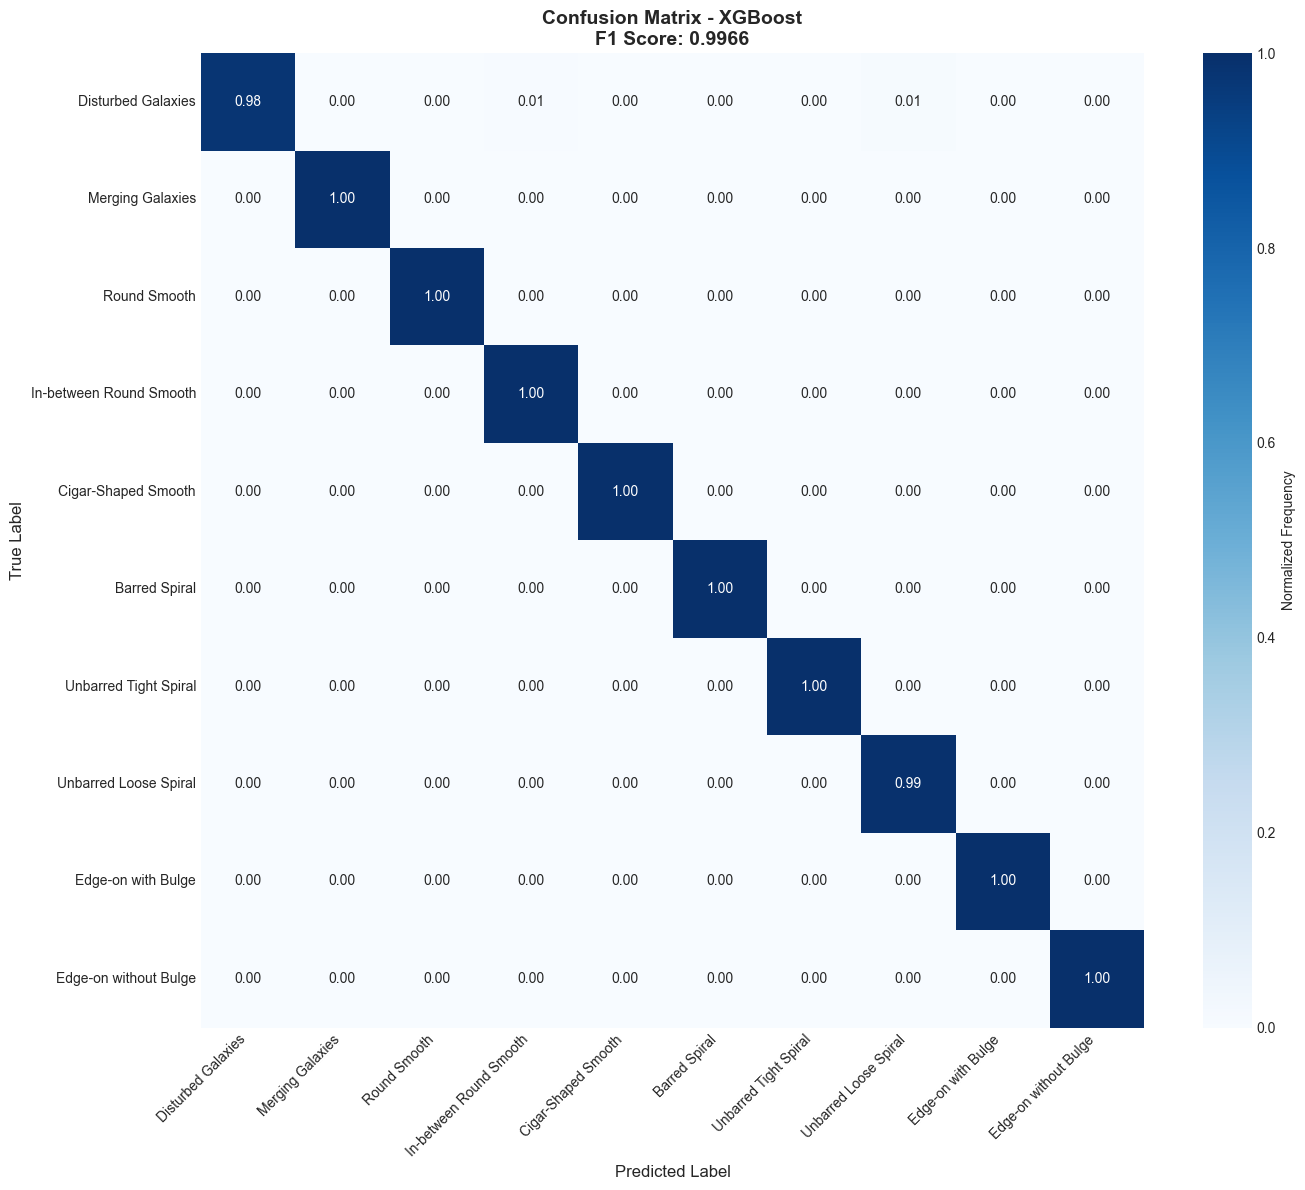

 Saved confusion matrix to artifacts/visualizations/confusion_matrix.png


In [12]:
print("="*70)
print("Generating Confusion Matrix")
print("="*70)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Normalized Frequency'}, ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name}\nF1 Score: {train_f1:.4f}', 
            fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../artifacts/visualizations/confusion_matrix.png', dpi=600, bbox_inches='tight')
plt.show()

print(" Saved confusion matrix to artifacts/visualizations/confusion_matrix.png")

## 13. Comprehensive Classification Metrics

In [13]:
print("="*70)
print("Comprehensive Classification Report")
print("="*70)

# Full classification report
print("\n Detailed Classification Report:\n")
print(classification_report(y, y_pred, target_names=CLASS_NAMES, digits=4))

# Overall metrics
accuracy = accuracy_score(y, y_pred)
f1_macro = f1_score(y, y_pred, average='macro')
f1_micro = f1_score(y, y_pred, average='micro')
f1_weighted = f1_score(y, y_pred, average='weighted')

print("\n Overall Metrics:")
print(f"  • Accuracy: {accuracy:.4f}")
print(f"  • F1 Score (Macro): {f1_macro:.4f}")
print(f"  • F1 Score (Micro): {f1_micro:.4f}")
print(f"  • F1 Score (Weighted): {f1_weighted:.4f}")

Comprehensive Classification Report

 Detailed Classification Report:

                         precision    recall  f1-score   support

     Disturbed Galaxies     0.9925    0.9796    0.9860      1081
       Merging Galaxies     0.9946    0.9978    0.9962      1853
           Round Smooth     0.9977    0.9985    0.9981      2645
In-between Round Smooth     0.9970    1.0000    0.9985      2027
    Cigar-Shaped Smooth     1.0000    0.9970    0.9985       334
          Barred Spiral     0.9980    0.9995    0.9988      2043
  Unbarred Tight Spiral     0.9962    0.9984    0.9973      1829
  Unbarred Loose Spiral     0.9943    0.9928    0.9935      2628
     Edge-on with Bulge     0.9993    0.9979    0.9986      1423
  Edge-on without Bulge     0.9979    0.9979    0.9979      1873

               accuracy                         0.9966     17736
              macro avg     0.9968    0.9959    0.9963     17736
           weighted avg     0.9966    0.9966    0.9966     17736


 Overall Metric

## 14. ROC Curves for All Classes

Generating ROC Curves


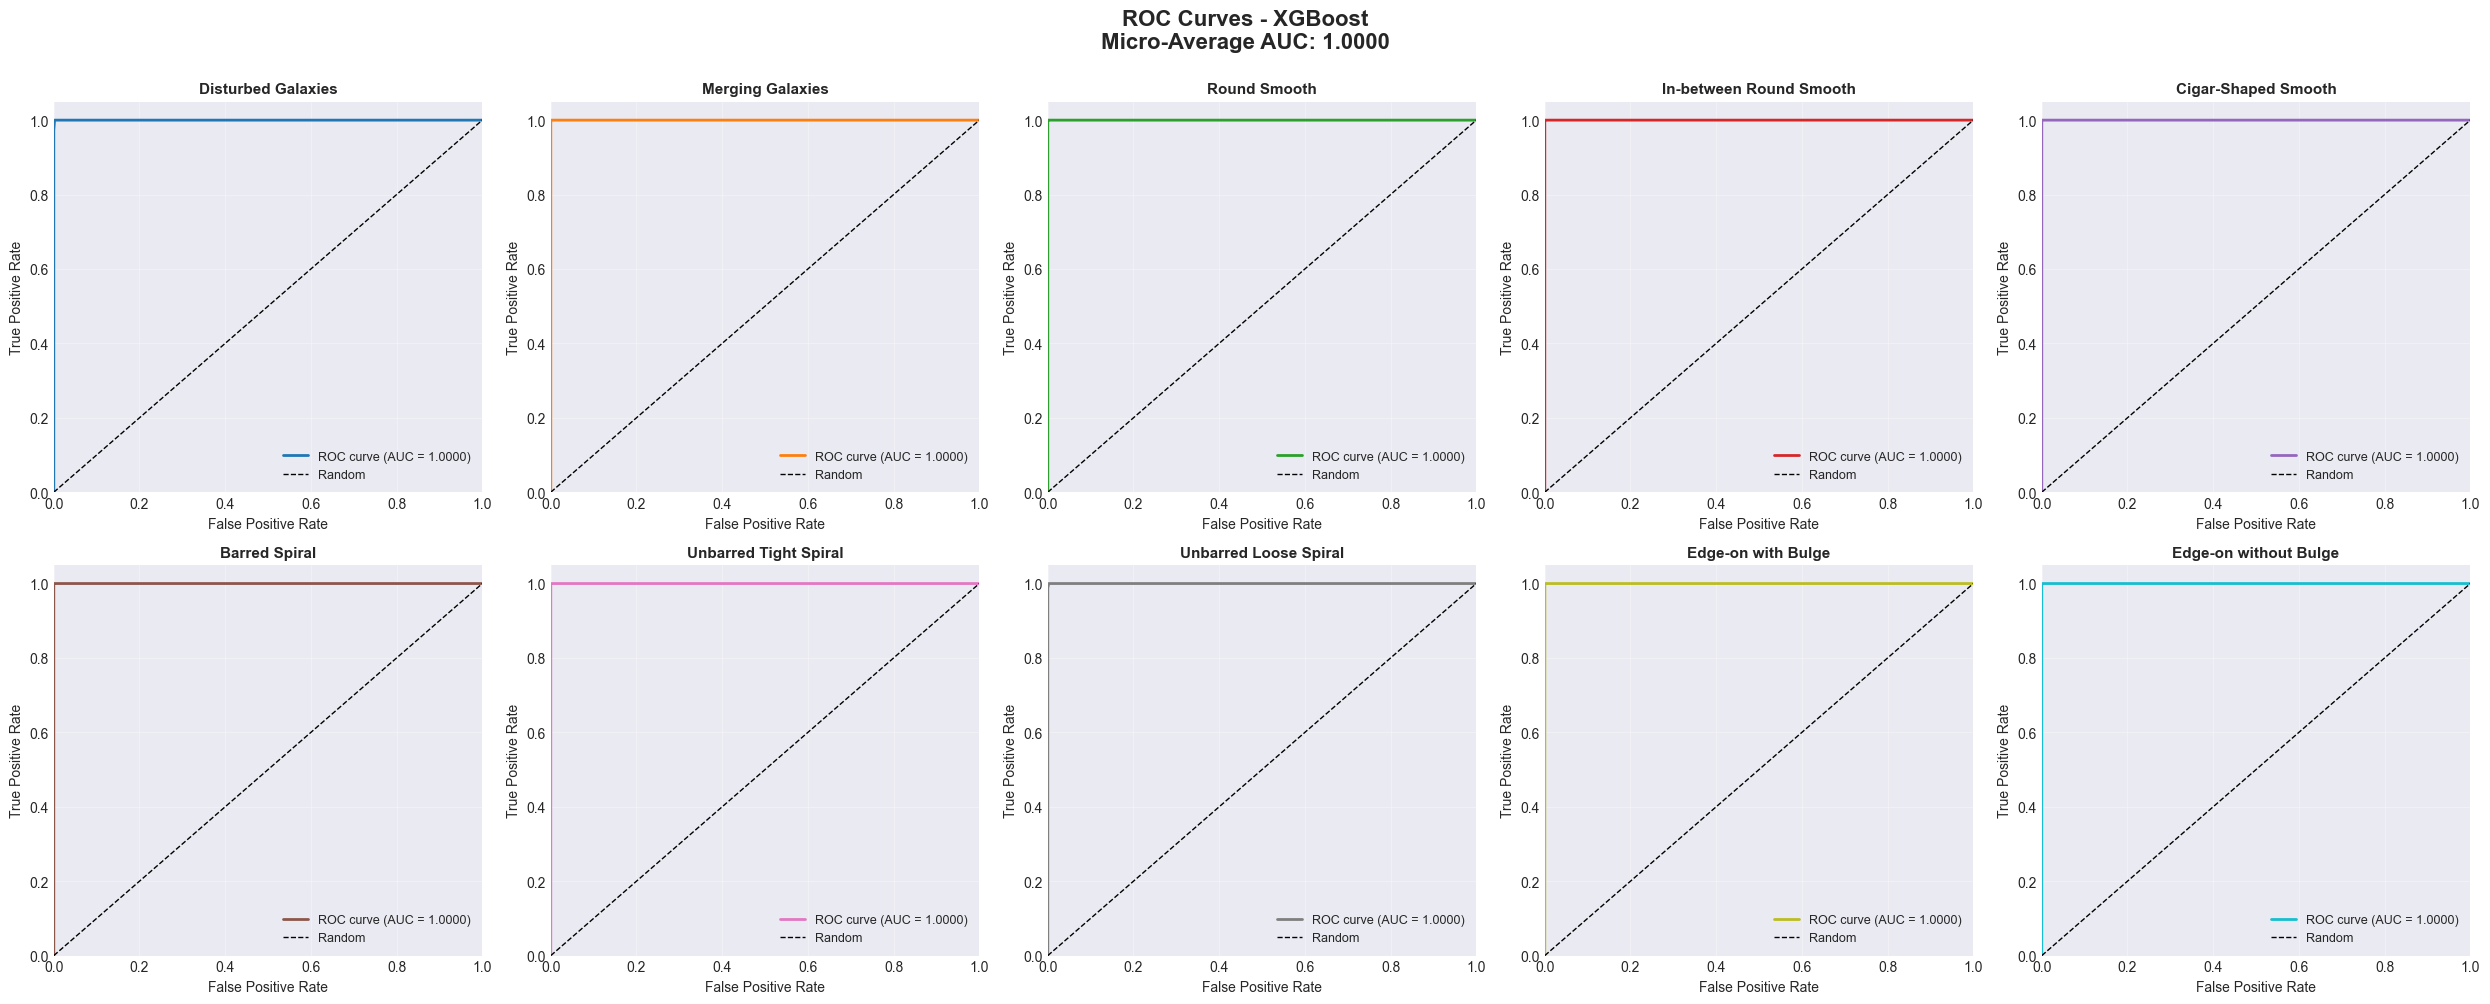


✓ ROC curves saved to artifacts/visualizations/roc_curves.png

📊 AUC Scores per Class:
  • Disturbed Galaxies: 1.0000
  • Merging Galaxies: 1.0000
  • Round Smooth: 1.0000
  • In-between Round Smooth: 1.0000
  • Cigar-Shaped Smooth: 1.0000
  • Barred Spiral: 1.0000
  • Unbarred Tight Spiral: 1.0000
  • Unbarred Loose Spiral: 1.0000
  • Edge-on with Bulge: 1.0000
  • Edge-on without Bulge: 1.0000
  • Micro-Average: 1.0000

✓ AUC scores saved to artifacts/visualizations/auc_scores.csv


In [ ]:
print("="*70)
print("Generating ROC Curves")
print("="*70)

# Get probability predictions (if model supports it)
if hasattr(best_clf, 'predict_proba'):
    y_proba = best_clf.predict_proba(X_scaled)
    
    # Binarize labels for ROC curve
    y_bin = label_binarize(y, classes=np.arange(10))
    n_classes = y_bin.shape[1]
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    axes = axes.ravel()
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i in range(n_classes):
        ax = axes[i]
        ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'ROC curve (AUC = {roc_auc[i]:.4f})')
        ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=10)
        ax.set_ylabel('True Positive Rate', fontsize=10)
        ax.set_title(f'{CLASS_NAMES[i]}', fontsize=11, fontweight='bold')
        ax.legend(loc="lower right", fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.suptitle(f'ROC Curves - {best_model_name}\nMicro-Average AUC: {roc_auc["micro"]:.4f}',
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('../artifacts/visualizations/roc_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ ROC curves saved to artifacts/visualizations/roc_curves.png")
    print(f"\n AUC Scores per Class:")
    for i in range(n_classes):
        print(f"  • {CLASS_NAMES[i]}: {roc_auc[i]:.4f}")
    print(f"  • Micro-Average: {roc_auc['micro']:.4f}")
    
    # Save AUC scores
    auc_df = pd.DataFrame([
        {'Class': CLASS_NAMES[i], 'AUC': f"{roc_auc[i]:.4f}"}
        for i in range(n_classes)
    ])
    auc_df.to_csv('../artifacts/visualizations/auc_scores.csv', index=False)
    print(f"\n✓ AUC scores saved to artifacts/visualizations/auc_scores.csv")
    
else:
    print(f"\n {best_model_name} does not support probability predictions.")
    print("   ROC curves cannot be generated for this model.")

## 15. Precision-Recall Curves

Generating Precision-Recall Curves


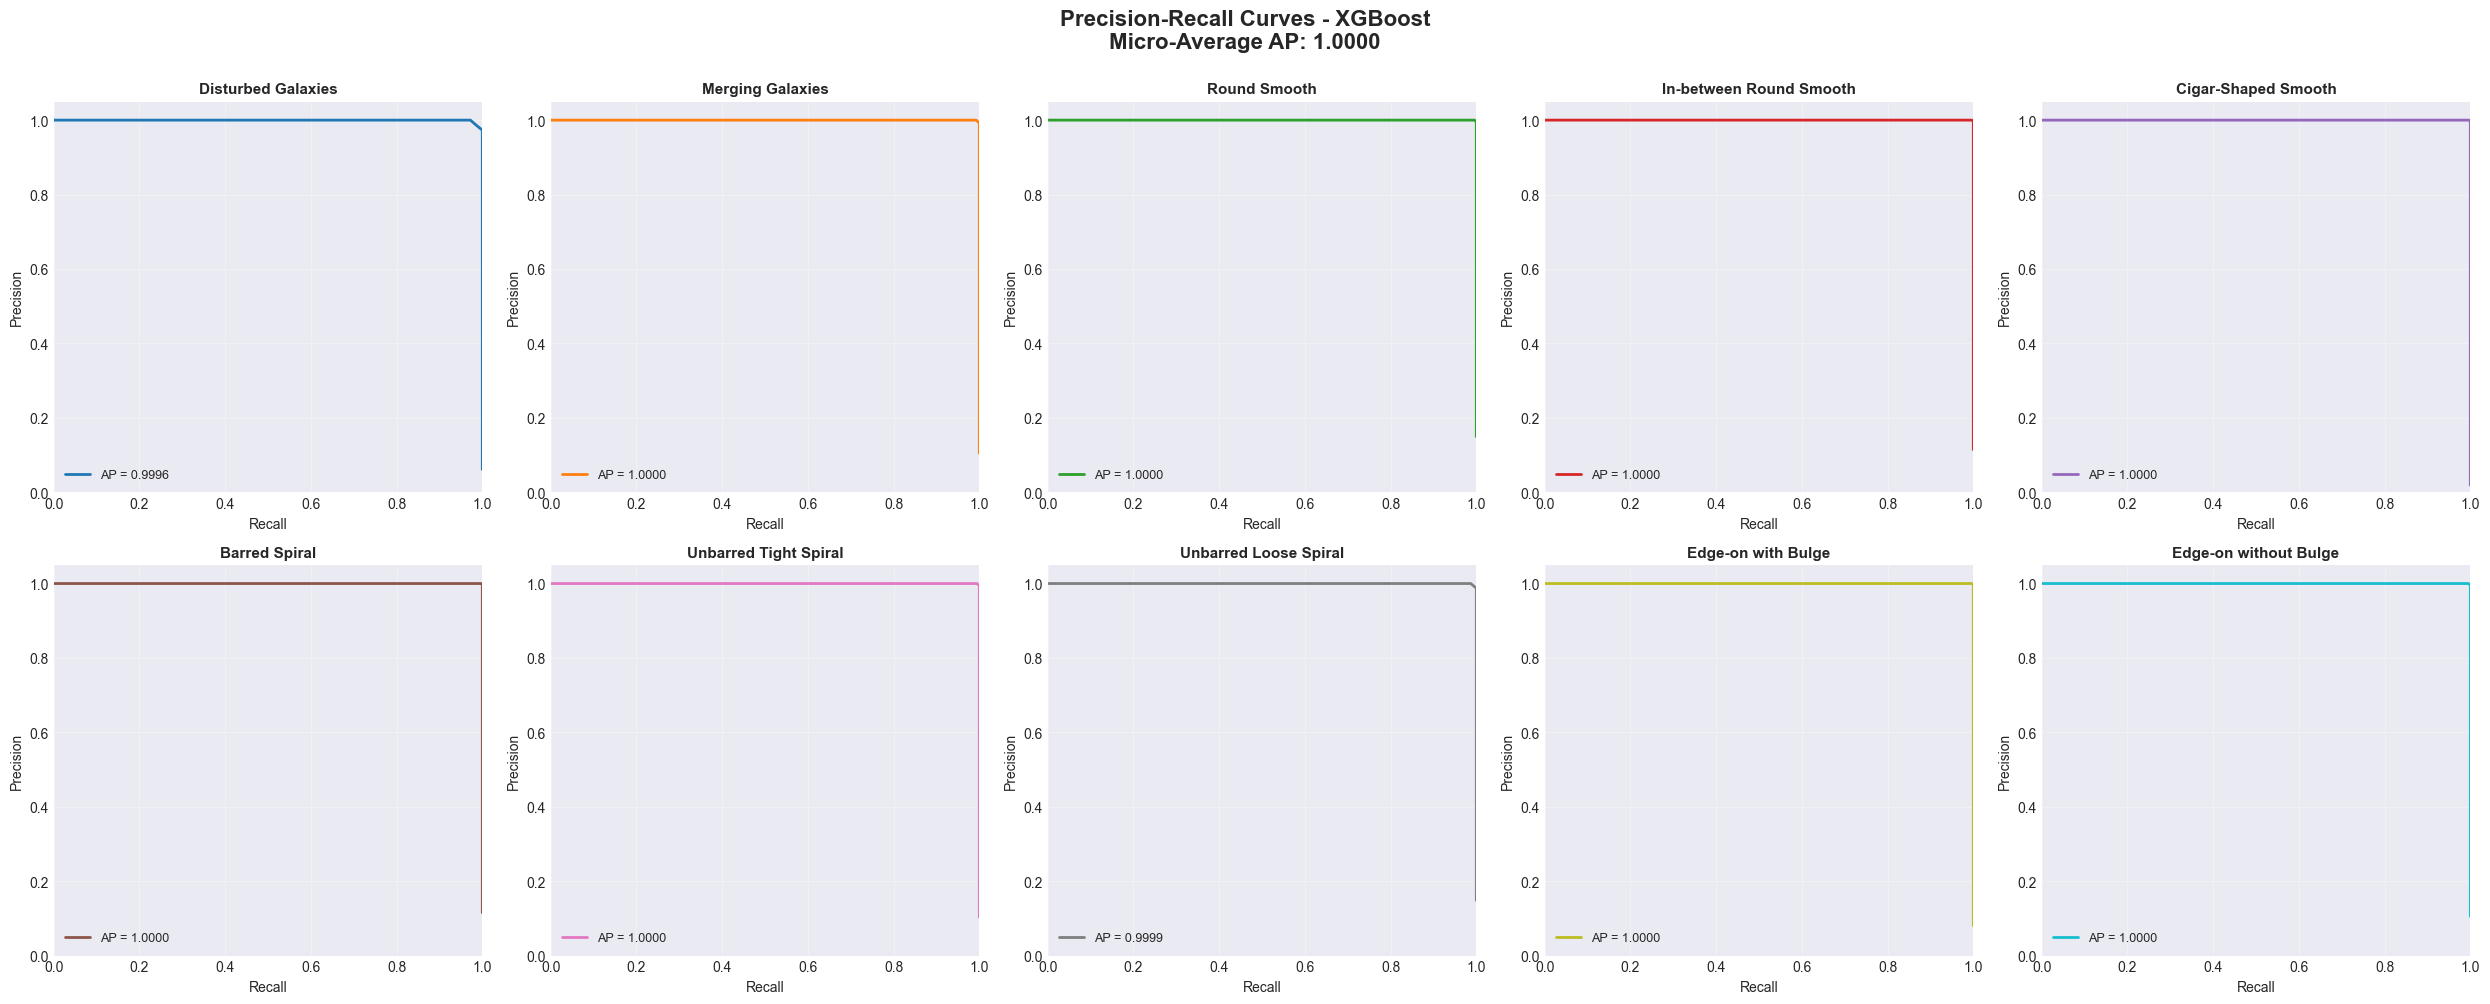


 Precision-Recall curves saved to artifacts/visualizations/precision_recall_curves.png

 Average Precision Scores per Class:
  • Disturbed Galaxies: 0.9996
  • Merging Galaxies: 1.0000
  • Round Smooth: 1.0000
  • In-between Round Smooth: 1.0000
  • Cigar-Shaped Smooth: 1.0000
  • Barred Spiral: 1.0000
  • Unbarred Tight Spiral: 1.0000
  • Unbarred Loose Spiral: 0.9999
  • Edge-on with Bulge: 1.0000
  • Edge-on without Bulge: 1.0000
  • Micro-Average: 1.0000


In [15]:
print("="*70)
print("Generating Precision-Recall Curves")
print("="*70)

if hasattr(best_clf, 'predict_proba'):
    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
        avg_precision[i] = average_precision_score(y_bin[:, i], y_proba[:, i])
    
    # Compute micro-average
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_bin.ravel(), y_proba.ravel()
    )
    avg_precision["micro"] = average_precision_score(y_bin, y_proba, average="micro")
    
    # Plot Precision-Recall curves
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    axes = axes.ravel()
    
    for i in range(n_classes):
        ax = axes[i]
        ax.plot(recall[i], precision[i], color=colors[i], lw=2,
                label=f'AP = {avg_precision[i]:.4f}')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Recall', fontsize=10)
        ax.set_ylabel('Precision', fontsize=10)
        ax.set_title(f'{CLASS_NAMES[i]}', fontsize=11, fontweight='bold')
        ax.legend(loc="lower left", fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.suptitle(f'Precision-Recall Curves - {best_model_name}\nMicro-Average AP: {avg_precision["micro"]:.4f}',
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('../artifacts/visualizations/precision_recall_curves.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    print(f"\n Precision-Recall curves saved to artifacts/visualizations/precision_recall_curves.png")
    print(f"\n Average Precision Scores per Class:")
    for i in range(n_classes):
        print(f"  • {CLASS_NAMES[i]}: {avg_precision[i]:.4f}")
    print(f"  • Micro-Average: {avg_precision['micro']:.4f}")
else:
    print(f"\n  {best_model_name} does not support probability predictions.")

## 16. Save Best Model

In [16]:
print("="*70)
print("Saving Best Model")
print("="*70)

# Save model
os.makedirs(MODELS_DIR, exist_ok=True)
model_path = os.path.join(MODELS_DIR, 'best_classifier.pkl')
joblib.dump(best_clf, model_path)
print(f"\n✓ Model saved to: {model_path}")

# Save training results
results_with_best = {
    'best_model': best_model_name,
    'best_f1': best_f1,
    'train_f1': train_f1,
    'all_results': results
}

results_path = os.path.join(MODELS_DIR, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results_with_best, f, indent=2)
print(f" Results saved to: {results_path}")

Saving Best Model

✓ Model saved to: artifacts/models/best_classifier.pkl
 Results saved to: artifacts/models/training_results.json


## 14. Summary Report

In [ ]:
print("="*70)
print(" ENSEMBLE TRAINING SUMMARY")
print("="*70)

print(f"\n Trained on {len(y):,} galaxy images")
print(f" Feature dimension: {X.shape[1]} (ViT + EfficientNet + CLIP)")

print(f"\n Best Model: {best_model_name}")
print(f" Cross-Validation F1: {best_f1:.4f}")
print(f" Training F1: {train_f1:.4f}")

print(f"\n All Models:")
for name, res in results.items():
    marker = "🏆" if name == best_model_name else "  "
    print(f"{marker} {name}: {res['mean_f1']:.4f} ± {res['std_f1']:.4f}")

print(f"\n Saved Artifacts:")
print(f"  • {model_path}")
print(f"  • {scaler_path}")
print(f"  • {results_path}")
print(f"  • {per_class_path}")
print(f"  • ../artifacts/visualizations/classifier_comparison.png")
print(f"  • ../artifacts/visualizations/confusion_matrix.png")

print(f"\n Next Steps:")
print(f"  1. Run 04_visualization.ipynb for FiftyOne integration")
print(f"  2. Explore UMAP/t-SNE projections")
print(f"  3. Use CLIP for text-based similarity search")
print(f"  4. Run 05_anomaly_detection.ipynb to find outliers")

print("\n" + "="*70)
print(" Ensemble training complete! Ready for visualization.")
print("="*70)

 ENSEMBLE TRAINING SUMMARY

 Trained on 17,736 galaxy images
 Feature dimension: 2176 (ViT + EfficientNet + CLIP)

 Best Model: XGBoost
🏆 Cross-Validation F1: 0.6819
🏆 Training F1: 0.9966

📈 All Models:
   Logistic Regression: 0.6559 ± 0.0076
   Random Forest: 0.5864 ± 0.0080
   Extra Trees: 0.5733 ± 0.0061
🏆 XGBoost: 0.6819 ± 0.0053
   K-Nearest Neighbors: 0.5296 ± 0.0066

💾 Saved Artifacts:
  • artifacts/models/best_classifier.pkl
  • artifacts/models/scaler.pkl
  • artifacts/models/training_results.json
  • ../artifacts/visualizations/per_class_metrics.csv
  • ../artifacts/visualizations/classifier_comparison.png
  • ../artifacts/visualizations/confusion_matrix.png

🎯 Next Steps:
  1. Run 04_visualization.ipynb for FiftyOne integration
  2. Explore UMAP/t-SNE projections
  3. Use CLIP for text-based similarity search
  4. Run 05_anomaly_detection.ipynb to find outliers

✅ Ensemble training complete! Ready for visualization.


## References
 **Journals**

1. Dosovitskiy et al., "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", *ICLR 2021*. DOI: [10.48550/arXiv.2010.11929](https://doi.org/10.48550/arXiv.2010.11929)
2. Tan & Le, "EfficientNetV2: Smaller Models and Faster Training", *ICML 2021*. DOI: [10.48550/arXiv.2104.00298](https://doi.org/10.48550/arXiv.2104.00298)
3. Radford et al., "Learning Transferable Visual Models From Natural Language Supervision", *ICML 2021*. DOI: [10.48550/arXiv.2103.00020](https://doi.org/10.48550/arXiv.2103.00020)
4. Cox, "The Regression Analysis of Binary Sequences", *JRSS B*, 1958. DOI: [10.1111/j.2517-6161.1958.tb00292.x](https://doi.org/10.1111/j.2517-6161.1958.tb00292.x)
5. Breiman, "Random Forests", *Machine Learning*, 2001. DOI: [10.1023/A:1010933404324](https://doi.org/10.1023/A:1010933404324)
6. Geurts et al., "Extremely Randomized Trees", *Machine Learning*, 2006. DOI: [10.1007/s10994-006-6226-1](https://doi.org/10.1007/s10994-006-6226-1)
7. Chen & Guestrin, "XGBoost: A Scalable Tree Boosting System", *KDD 2016*. DOI: [10.1145/2939672.2939785](https://doi.org/10.1145/2939672.2939785)
8. Cover & Hart, "Nearest Neighbor Pattern Classification", *IEEE Trans. Info. Theory*, 1967. DOI: [10.1109/TIT.1967.1053964](https://doi.org/10.1109/TIT.1967.1053964)

**Core Textbooks**
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning.* Springer.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning.* Springer.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning.* MIT Press.
- Murphy, K. P. (2012). *Machine Learning: A Probabilistic Perspective.* MIT Press.

**Vision & Representation Learning**
- Szeliski, R. (2022). *Computer Vision: Algorithms and Applications.* Springer.
- Bengio, Y., Courville, A., & Vincent, P. (2013). *Representation Learning: A Review and New Perspectives.* IEEE TPAMI, 35(8), 1798–1828.

**Practical Guides**
- Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow.* O’Reilly Media.
- Alpaydin, E. (2020). *Introduction to Machine Learning.* MIT Press.

**Online Resources**
- Andrew Ng (Coursera). *Machine Learning Course.*
- Fast.ai. *Practical Deep Learning for Coders.*
